# BRG Insights - Modelo de Regressão Logística aplicado à LeadScore 

<b> Problemática: </b>
    
    Utilizar o modelo de Regressão Logística com Aprendizagem Supervisionada para definir a probabilidade (0 a 1) do candidato se matricular naquela instituição, de acordo com as variáveis quantitativas e qualitativas.


IMPORT DAS BIBLIOTECAS NECESSÁRIAS PARA CONSTRUÇÃO DO MODELO

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

REALIZANDO O TRATAMENTO DOS DADOS E TRANSFORMAÇÃO DAS VARIÁVEIS CATEGÓRICAS

In [2]:
# Carga das Bases de Dados

df_base = pd.read_csv("Results3.csv",encoding='cp1252')
df_kroton = pd.read_csv("kroton-2018.csv",encoding='cp1252',sep=";")[["ID Bearings","Flag_Matriculado"]]

In [3]:
# Tratando o Campo ID Bearings para compatibilidade com a Base Treino

df_kroton['ID Bearings'] = df_kroton['ID Bearings'].str[:-7]
df_kroton['Id_final'] = df_kroton['ID Bearings'].str.split('-',n=1,expand=True)[1]

In [4]:
# Criando o DataFrame unico com o Flag Matrículas 

df = df_base.merge(df_kroton,left_on="Id",right_on="Id_final",how='left')

In [5]:
# Eliminando Colunas Desnecessárias

df = df.drop(columns=['ID Bearings','Id_final', 'SchoolYearId'])

In [6]:
# Acrescentando Dados de Cidade (Tipo e UF)

df_municipio = pd.read_excel("Tabela_Municipio.xlsx")[['CO_QC?','NOME (C.ACENTO)','NO_UF','CIDADE_TIPO']]

In [7]:
df = df.merge(df_municipio,left_on='CityId',right_on='CO_QC?',how='left')

In [8]:
# Padronizando a Base 

df = df.drop(columns=['CO_QC?'])
df = df.rename(columns={'Description':'SchoolYear','NOME (C.ACENTO)':'CityName','NO_UF':'UF','CIDADE_TIPO':'CityType','to_date':'date'})

In [9]:
# Transformando Flag Matrículas em Variável Binária

df['Flag_Matriculado'].fillna(0,inplace=True)

In [10]:
# Impossibilidade Usar o campo YearToJoinCollege devido ao tamanho de valores Nulos

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 927825 entries, 0 to 927824
Data columns (total 13 columns):
Id                   927825 non-null object
Age                  927825 non-null int64
CityId               814542 non-null float64
date                 927825 non-null object
Email                927505 non-null object
PhoneNumber          845790 non-null object
SocialClassId        810130 non-null object
YearToJoinCollege    249687 non-null float64
SchoolYear           927825 non-null object
Flag_Matriculado     927825 non-null float64
CityName             814542 non-null object
UF                   814542 non-null object
CityType             814542 non-null object
dtypes: float64(3), int64(1), object(9)
memory usage: 99.1+ MB


In [11]:
df = df.drop(columns=['YearToJoinCollege'])

CRIANDO AS VARIÁVEIS CONTÍNUAS COM BASE EM PESO NAS VARIÁVEIS CATEGÓRICAS

In [12]:
df.fillna(0,inplace=True)

In [13]:
# Criação das Variáveis Booleanas

df['PhoneNumberbool'] = np.where(df['PhoneNumber']==0,0,1)
df['Emailbool'] = np.where(df['Email']==0,0,1)

In [14]:
# Variáveis Categóricas

from sklearn.preprocessing import LabelEncoder

In [15]:
df['CityType'] = df['CityType'].replace({0:'NAO DECLARADO'})
df['UF'] = df['UF'].replace({0:'NAO DECLARADO'})
df['SocialClassId'] = df['SocialClassId'].replace({0:'NAO DECLARADO'})

In [16]:
gle = LabelEncoder()

citytype_labels = gle.fit_transform(df['CityType'])
citytype_mappings = {index: label for index, label in 
                  enumerate(gle.classes_)}

uf_labels = gle.fit_transform(df['UF'])
uf_mappings = {index: label for index, label in 
                  enumerate(gle.classes_)}

In [17]:
df['v_CityType'] = citytype_labels
df['v_UF'] = uf_labels

In [18]:
df['SocialClassId'].unique()

array(['D', 'C', 'B', 'NAO DECLARADO', 'I', 'E', 'A'], dtype=object)

In [19]:
# Atribuindo Ordinais a Renda (Lembrando que não é Linear)
socialclass_ord_map = {'I' :0, 'E' :1, 'D' :2, 'C' :3, 'B' :4, 'A' :5}

In [20]:
df['v_SocialClassId'] = df['SocialClassId'].map(socialclass_ord_map)

In [21]:
df['SchoolYear'].unique()

array(['2º ano - Ens. Médio', 'Outros', 'Cursinho', '1º ano - Ens. Médio',
       'Superior completo', 'Superior incompleto', '3º ano - Ens. Médio',
       'Ens. Fundamental'], dtype=object)

In [22]:
schoolyear_ord_map = {
    'Outros':0,
    'Ens. Fundamental':1,
    '1º ano - Ens. Médio':2,
    '2º ano - Ens. Médio':3,
    '3º ano - Ens. Médio':4,
    'Cursinho':5,
    'Superior incompleto':6,
    'Superior completo':7 }

In [23]:
df['v_SchoolYear'] = df['SchoolYear'].map(schoolyear_ord_map)

In [24]:
df['Age'] = np.where(df['Age']>99,18,df['Age'])
df['Age'] = np.where(df['Age']<0,18,df['Age'])

CALCULANDO OS VALORES QUANTITATIVOS

In [25]:
# Cálculo do Percentual de Matrículas por UF 

conversao_uf = df.groupby('v_UF').agg({'Id':'count','Flag_Matriculado':'sum'}).reset_index()
conversao_uf['p_conversao'] = conversao_uf['Flag_Matriculado'] / conversao_uf['Id']
conversao_uf = conversao_uf[['v_UF','p_conversao']]

In [26]:
features = df[df['Flag_Matriculado']==1][['Id','Flag_Matriculado','PhoneNumberbool','Emailbool','v_CityType','v_UF','v_SocialClassId','v_SchoolYear']]

In [27]:
phonenumberbool = features.groupby('PhoneNumberbool').agg({'Id':'count'}).reset_index()
phonenumberbooltotal = phonenumberbool['Id'].sum()
phonenumberbool['p_PhoneNumberbool'] = phonenumberbool['Id'] / phonenumberbooltotal
phonenumberbool = phonenumberbool.drop(columns=['Id'])

In [28]:
# Não Faz Sentido ponderar por email, visto que todos os leads enviados tem, pelo menos, o email como obrigação 

#emailbool = features.groupby('Emailbool').agg({'Id':'count'}).reset_index()
#emailbooltotal = emailbool['Id'].sum()
#emailbool['p_emailbool'] = emailbool['Id'] / emailbooltotal
#emailbool = emailbool.drop(columns=['Id'])

In [29]:
vcitytype = features.groupby('v_CityType').agg({'Id':'count'}).reset_index()
vcitytypetotal = vcitytype['Id'].sum()
vcitytype['p_CityType'] = vcitytype['Id'] / vcitytypetotal
vcitytype = vcitytype.drop(columns=['Id'])

In [30]:
vuf = features.groupby('v_UF').agg({'Id':'count'}).reset_index()
vuftotal = vuf['Id'].sum()
vuf['p_UF'] = vuf['Id'] / vuftotal
vuf = vuf.drop(columns=['Id'])

In [31]:
vsocialclass = features.groupby('v_SocialClassId').agg({'Id':'count'}).reset_index()
vsocialclasstotal = vsocialclass['Id'].sum()
vsocialclass['p_SocialClass'] = vsocialclass['Id'] / vsocialclasstotal
vsocialclass = vsocialclass.drop(columns=['Id'])

In [32]:
vschoolyear = features.groupby('v_SchoolYear').agg({'Id':'count'}).reset_index()
vschoolyeartotal = vschoolyear['Id'].sum()
vschoolyear['p_SchoolYear'] = vschoolyear['Id'] / vschoolyeartotal
vschoolyear = vschoolyear.drop(columns=['Id'])

In [33]:
df = df.merge(phonenumberbool)
#df = df.merge(emailbool)
df = df.merge(vcitytype)
df = df.merge(vuf)
df = df.merge(vsocialclass)
df = df.merge(vschoolyear)
df = df.merge(conversao_uf)

In [34]:
df.dtypes

Id                    object
Age                    int64
CityId               float64
date                  object
Email                 object
PhoneNumber           object
SocialClassId         object
SchoolYear            object
Flag_Matriculado     float64
CityName              object
UF                    object
CityType              object
PhoneNumberbool        int32
Emailbool              int32
v_CityType             int32
v_UF                   int32
v_SocialClassId      float64
v_SchoolYear           int64
p_PhoneNumberbool    float64
p_CityType           float64
p_UF                 float64
p_SocialClass        float64
p_SchoolYear         float64
p_conversao          float64
dtype: object

# CONSTRUÇÃO DO MODELO

In [35]:
# Trazendo todos os matriculados para a base treino

df_treino_x = df[df['Flag_Matriculado']==1]

In [36]:
# Retirando uma amostragem de não matriculados de igual tamanho para balancear a amostra a ser treinada

df_treino_y = df[df['Flag_Matriculado']==0].sample(frac=0.00255)

In [37]:
df_treino_1 = pd.concat([df_treino_x,df_treino_y])

In [38]:
df_treino_1.shape

(2731, 24)

In [39]:
# Coletando 80% da Base para Treino

df_treino = df_treino_1.sample(frac=0.8)

In [40]:
# Reservando 20% da Base para Teste 

df_treino['flag 20%'] = 1

In [41]:
df_20p = df_treino[['Id','flag 20%']]

In [42]:
df_teste = df_treino_1.merge(df_20p,how='left')
df_teste = df_teste[df_teste['flag 20%'].isna()]

In [43]:
print(df_treino.shape,df_teste.shape)

(2185, 25) (546, 25)


<b> TREINAMENTO DO MODELO (80% DA BASE)

In [44]:
# Criando a Base para Treino apenas com as variáveis que importam (Flag Matriculado é o Y)

df_treino = df_treino[['Age','p_PhoneNumberbool','p_CityType','p_UF','p_SocialClass','p_SchoolYear','p_conversao','Flag_Matriculado']]
#df_treino = df[['p_PhoneNumberbool','p_CityType','p_UF','p_SocialClass','p_SchoolYear','Flag_Matriculado']]

SEPARANDO X DE Y

In [45]:
n_features = len(df_treino.columns)-1

X = np.array(df_treino.drop('Flag_Matriculado',1))
y = df_treino.iloc[:,n_features:n_features+1].values

ARMAZENANDO NA MEMÓRIA OS DADOS DE MÉDIA E DESVIO PADRÃO ANTES DO STANDARSCALLER

In [46]:
mean = X.mean(axis=0)
std = X.std(axis=0)

PADRONIZAÇÃO DOS DADOS

In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [48]:
scaler.fit(X)
X = scaler.transform(X)

CRIANDO X0 PARA VALORES =1

In [49]:
def insert_ones(X):
    ones = np.ones([X.shape[0],1])
    return np.concatenate((ones,X),axis=1)

CRIANDO UM VETOR DE W's BASEADO NA QUANTIDADE DE FEATURES

In [50]:
w = np.random.rand(1,n_features+1) ## valores entre 0 e 1
w

array([[0.51880836, 0.58450559, 0.9039106 , 0.25577574, 0.80388405,
        0.71920147, 0.16546644, 0.14965242]])

SIGMOID

In [51]:
def sigmoid(z):
    return 1 / ( 1 + np.exp(-z))

SIMULANDO A SIGMOID

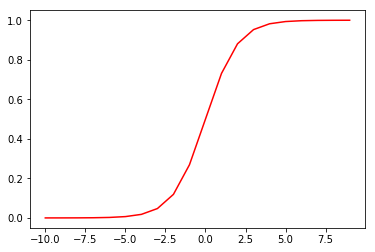

In [52]:
nums = np.arange(-10, 10, step=1) ## criando uma distribuição entre -10 e 10

## plotando 
fig, ax = plt.subplots(figsize=(6,4))  
ax.plot(nums, sigmoid(nums), 'r')

BINARY CROSS ENTROPY: -y log (y^) - (1-y) log(1-y^)

In [53]:

def binary_cross_entropy(w, X, y):    
    
    m = len(X)
    
    parte1 = np.multiply(-y, np.log(sigmoid(X @ w.T)))
    parte2 = np.multiply((1 - y), np.log(1 - sigmoid(X @ w.T)))
    
    somatorio = np.sum(parte1 - parte2)
    
    return  somatorio/m

GRADIENT DESCENDENT


In [54]:

def gradient_descent(w,X,y,alpha,epoch):
    cost = np.zeros(epoch)
    for i in range(epoch):
        w = w - (alpha/len(X)) * np.sum((sigmoid(X @ w.T) - y)*X, axis=0)
        cost[i] = binary_cross_entropy(w, X, y)
    
    return w,cost

TREINAMENTO

In [55]:
X = insert_ones(X)

In [56]:
alpha= 0.01 # taxa de aprendizado
epoch = 1000

In [57]:
w, cost = gradient_descent(w, X, y, alpha, epoch)

Text(0.5, 1.0, 'Erro vs. Epoch')

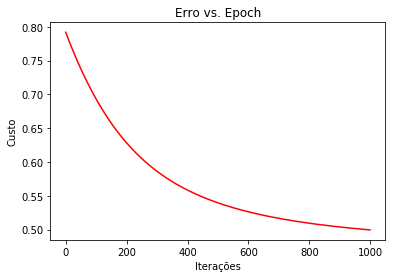

In [58]:
fig, ax = plt.subplots()  
ax.plot(np.arange(epoch), cost, 'r')  
ax.set_xlabel('Iterações')  
ax.set_ylabel('Custo')  
ax.set_title('Erro vs. Epoch')

In [59]:
w

array([[9.02107567e-04, 3.28339773e-01, 6.87542252e-01, 2.24204721e-01,
        1.45075572e-01, 8.35568460e-02, 1.12117399e+00, 4.54213026e-01]])

<b> TESTE DO MODELO (20% DA BASE)

APLICAÇÃO

In [60]:
df_teste.sort_values('p_PhoneNumberbool',ascending=True).head(5)

,Id,Age,CityId,date,Email,PhoneNumber,SocialClassId,SchoolYear,Flag_Matriculado,CityName,...,v_UF,v_SocialClassId,v_SchoolYear,p_PhoneNumberbool,p_CityType,p_UF,p_SocialClass,p_SchoolYear,p_conversao,flag 20%
85,9b7f6124-a555-4235-9dac-b05d7c19fe83,20,8521.0,2017-04-01,marcos-paulo_borgonovo@hotmail.com,0,C,Outros,1.0,Joinville,...,24,3.0,0,0.099937,0.274041,0.047769,0.542435,0.449403,0.002218,NaN
1,43793bd8-e4ca-40eb-b952-56389743f2af,17,2618.0,2017-06-16,rhurodrigues01@gmail.com,(98) 98315-5371,D,Outros,1.0,Vitorino Freire,...,9,2.0,0,0.900063,0.333752,0.020742,0.377860,0.449403,0.002983,NaN
1818,5b28990e-ef0d-4034-ae71-1f26cb90635b,19,1643.0,2017-11-09,renequeirooz11@hotmail.com,(85) 99965-8436,E,Superior incompleto,0.0,Redenção,...,5,1.0,6,0.900063,0.333752,0.015085,0.028782,0.339409,0.000832,NaN
1813,67d40ff5-7bca-4b06-87c6-05d9a43dd66d,16,9668.0,2017-08-13,edson_blopesjunior12@hotmail.com,(11) 98729-9421,C,3º ano - Ens. Médio,0.0,São Paulo,...,26,3.0,4,0.900063,0.274041,0.186675,0.542435,0.012571,0.001389,NaN
1806,3f0d845a-b381-4248-92af-15079693f8ae,18,7043.0,2019-01-30,elaineaparecida64@hotmail.com,(21) 98749-9046,C,Superior incompleto,0.0,Rio de Janeiro,...,19,3.0,6,0.900063,0.274041,0.047140,0.542435,0.339409,0.000834,NaN


In [61]:
def predict(w, X, threshold=0.5):
    p = sigmoid(X @ w.T) >= threshold
    return (p.astype('int'))

In [62]:
# Salvando os resultados do Treino

teste = np.array(df_teste[['Age','p_PhoneNumberbool','p_CityType','p_UF','p_SocialClass','p_SchoolYear','p_conversao']])
teste = (teste-mean)/std
teste = insert_ones(teste)

In [63]:
df_teste['LeadScore'] = sigmoid(teste@ w.T)

In [65]:
#predict(w, Lead1)

In [66]:
df_teste.to_csv('teste.csv',sep=';')

# CRIANDO O LEAD SCORE PARA TODA A BASE

In [67]:
final = np.array(df[['Age','p_PhoneNumberbool','p_CityType','p_UF','p_SocialClass','p_SchoolYear','p_conversao']])
final = (final-mean)/std
final = insert_ones(final)

In [68]:
df['LeadScore'] = sigmoid(final@ w.T)

# ANÁLISE DO LEAD SCORE

In [113]:
matriculado = df[df['Flag_Matriculado']==1]
n_matriculado = df[df['Flag_Matriculado']==0]
print(matriculado.shape,n_matriculado.shape)

(1355, 25) (539757, 25)


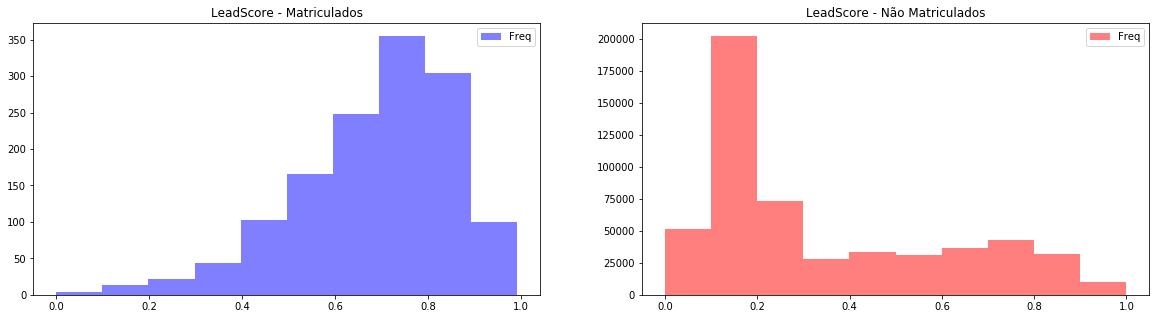

In [114]:
fig, axes = plt.subplots(1,2,sharey=False, sharex=False,figsize=(20,5))
axes[0].hist(matriculado['LeadScore'], color='b', label='Freq', alpha=0.5)
axes[0].legend(loc='best')
axes[0].set_title('LeadScore - Matriculados')
                         
axes[1].hist(n_matriculado['LeadScore'], color='r', label='Freq', alpha=0.5)
axes[1].legend(loc='best')
axes[1].set_title('LeadScore - Não Matriculados') ;  

In [115]:
matriculado['LeadScore_Faixa'] = matriculado['LeadScore'].round(1)
n_matriculado['LeadScore_Faixa'] = n_matriculado['LeadScore'].round(1)

C:\Users\Rodrigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Rodrigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [116]:
matriculado = matriculado.groupby('LeadScore_Faixa').agg({'Id':'count'}).reset_index()

In [123]:
matriculado['Total'] = matriculado['Id'].sum()

In [124]:
matriculado['percent'] = matriculado['Id']/matriculado['Total']

In [127]:
n_matriculado = n_matriculado.groupby('LeadScore_Faixa').agg({'Id':'count'}).reset_index()

In [128]:
n_matriculado['Total'] = n_matriculado['Id'].sum()

In [132]:
n_matriculado['percent'] = n_matriculado['Id']/n_matriculado['Total']

In [155]:
x = ['LS 0','LS 1','LS 2','LS 3','LS 4','LS 5','LS 6','LS 7','LS 8','LS 9','LS 10']
y = np.array(matriculado['percent'])
z =np.array(n_matriculado['percent'])

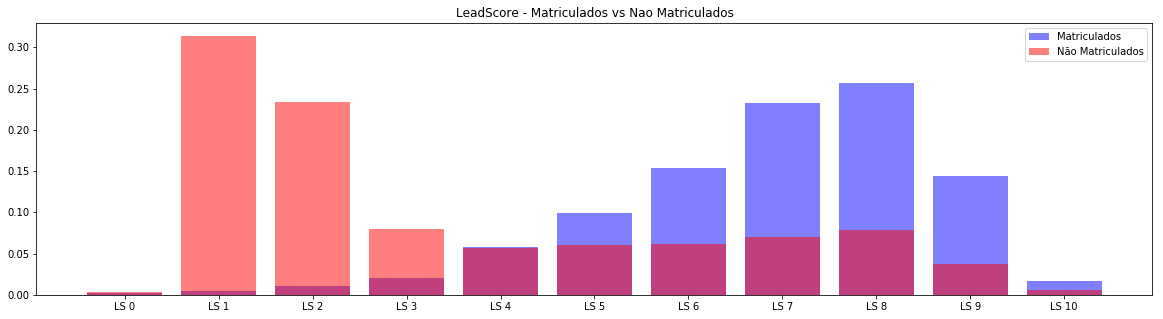

In [163]:
fig, axes = plt.subplots(figsize=(20,5))
axes.bar(x,y, color='b', label='Matriculados',alpha=0.5)
axes.bar(x,z, color='r', label='Não Matriculados',alpha=0.5) 
axes.legend(loc='best')
axes.set_title('LeadScore - Matriculados vs Nao Matriculados');